<a href="https://colab.research.google.com/github/ucaokylong/Some_small_projects/blob/main/Multi_style_Transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import zipfile

from pathlib import Path

import requests

data_path = Path("data")

data_path.mkdir(parents=True, exist_ok=True)

def request_image(link_of_image, name_of_image):
  with open(data_path / name_of_image, 'wb' ) as f:
    request = requests.get(link_of_image)
    print("DOWNLOADING IMAGE...", name_of_image)
    f.write(request.content)

In [2]:
request_image('https://th.bing.com/th/id/OIP.tkcm5lVuN5KVczv1vF939wHaFp?rs=1&pid=ImgDetMain',
              "style1.png")

DOWNLOADING IMAGE... style1.png


In [3]:
request_image("https://yining1023.github.io/machine-learning-for-the-web/week5-styleTransfer/styleTransfer-ml5/StyleTransfer_Image/img/wave.jpg",
              "style2.png")

DOWNLOADING IMAGE... style2.png


In [4]:
request_image("https://wallpaperaccess.com/full/98571.jpg","content.png")

DOWNLOADING IMAGE... content.png


In [5]:
from PIL import Image
import torchvision.transforms as transforms
import torch
import torch.nn as nn
imsize = 256
device = 'cpu'
img_transforms = transforms.Compose([
    transforms.Resize((imsize, imsize)),
    transforms.ToTensor()
]
)

def image_loader(image_name):
  image = Image.open(image_name)
  image = img_transforms(image).unsqueeze(0)
  return image.to(device, torch.float)

style_img1 = image_loader("/content/data/style1.png")
style_img2 = image_loader("/content/data/style2.png")
content_img = image_loader("/content/data/content.png")

In [6]:
# Content Loss
content_weight = 1

ContentLoss = nn.MSELoss()

#Style Loss
def gram_matrix(tensor):
  a,b,c,d = tensor.size()
  tensor = tensor.view(a*b, c*d)
  G = torch.mm(tensor, tensor.t())
  return G.div(a*b*c*d)

style_weight = 1e6
StyleLoss = nn.MSELoss()

In [7]:
from torchvision.models import vgg19 , VGG19_Weights

VGG19_pretrained = vgg19( weights = VGG19_Weights.DEFAULT).features.eval()
VGG19_pretrained.to( device )

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:08<00:00, 69.8MB/s]


Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [41]:
content_layers = ['conv_4']
style_layers = ["conv_1",'conv_2', "conv_3", "conv_4", "conv_5"]
#style_layers = ["conv_1"]
def get_features(pretrained_model , image):
  layers ={
      "0": "conv_1",
      "5": "conv_2",
      "10": "conv_3",
      "19": "conv_4",
      "28": "conv_5"
  }

  features ={}
  x = image
  for name, pretrained_layer in pretrained_model._modules.items():
    x = pretrained_layer(x)
    if name in layers:
      features[layers[name]] = x
  return features

In [42]:
def get_dual_style( style_features1 , style_features2 , style_layers ):
  final_style_features = {}
  for layer in style_layers:
    sf1 = style_features1[layer]
    sf2 = style_features2[layer]
    sf1_size = int( sf1.size()[1] / 4)
    final_style_features [ layer ] = torch.concatenate([sf1[: ,: sf1_size ,: ,:] ,
                                                           sf2[: , sf1_size : ,: ,:]] , dim =1)
    return final_style_features

content_features = get_features( VGG19_pretrained , content_img )
style_features1 = get_features( VGG19_pretrained , style_img1 )
style_features2 = get_features( VGG19_pretrained , style_img2 )
final_style_features = get_dual_style( style_features1 , style_features2 , style_layers )


print(style_features1.keys())



dict_keys(['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5'])


In [10]:
def rot_style_features( style_features , style_layers ):
  final_rot_style_features = {}
  for layer in style_layers:
    sf = style_features[ layer ].clone()
    rot90 = torch.rot90( sf.clone() , 1 , (2 , 3) )
    rot180 = torch.rot90( rot90.clone() , 1 , (2 , 3) )
    final_rot = sf + ( rot90 - rot180 )
    final_rot_style_features[ layer ] = final_rot
  return final_rot_style_features

content_features = get_features( VGG19_pretrained , content_img )
style_features1 = get_features( VGG19_pretrained , style_img1 )
final_rot_style_features = rot_style_features( style_features1 , style_layers )







In [43]:
import torch.optim as optim
target_img = content_img.clone().requires_grad_(True).to( device )
optimizer = optim.Adam([target_img] , lr =0.02)

In [44]:
import torch
import torchvision
from torchvision import transforms
import torch.nn as nn
import torch.optim as optim
from torch.optim import Adam
from torchvision.models import vgg19
from torch.autograd import Variable
from torch.utils.data import DataLoader
import copy

In [45]:
def style_transfer_( model , optimizer , target_img , content_features , style_features ,
                   style_layers , content_weight , style_weight ):
  optimizer.zero_grad()
  with torch.no_grad():
    target_img.clamp_(0 , 1)
  target_features = get_features( model , target_img )
  content_loss = ContentLoss( content_features['conv_4'] , target_features['conv_4'])

  style_loss = 0
  for layer in style_layers:
    target_gram = gram_matrix(target_features[layer])
    style_gram = gram_matrix(style_features[layer])
    style_loss += StyleLoss(style_gram, target_gram)

  total_loss = content_loss*content_weight + style_loss*style_weight
  total_loss.backward(retain_graph = True)
  optimizer.step()
  return total_loss, content_loss, style_loss








In [48]:
print(final_style_features.keys())
print(style_features1.keys())

dict_keys(['conv_1'])
dict_keys(['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5'])


In [49]:
STEPS = 2000

for step in range(STEPS):
  optimizer.zero_grad()
  with torch.no_grad():
    target_img.clamp_(0,1)

  total_loss, content_loss, style_loss = style_transfer_(
      VGG19_pretrained, optimizer, target_img, content_features, style_features1,
      style_layers, content_weight, style_weight)

  if step % 100 == 99:
    print(f"Epoch [{step+1}/{STEPS}] Total loss: {total_loss.item():.6f} - Content loss: {content_loss.item(): .6f} - Style loss: {style_loss.item():.6f}")

  with torch.no_grad():
    target_img.clamp_(0,1)


Epoch [100/2000] Total loss: 6.765240 - Content loss:  4.817302 - Style loss: 0.000002
Epoch [200/2000] Total loss: 6.708910 - Content loss:  4.922322 - Style loss: 0.000002
Epoch [300/2000] Total loss: 6.352984 - Content loss:  4.583676 - Style loss: 0.000002
Epoch [400/2000] Total loss: 6.333929 - Content loss:  4.681498 - Style loss: 0.000002
Epoch [500/2000] Total loss: 6.400433 - Content loss:  4.414133 - Style loss: 0.000002
Epoch [600/2000] Total loss: 6.192934 - Content loss:  4.683101 - Style loss: 0.000002
Epoch [700/2000] Total loss: 6.758316 - Content loss:  4.702713 - Style loss: 0.000002
Epoch [800/2000] Total loss: 6.231387 - Content loss:  4.717870 - Style loss: 0.000002
Epoch [900/2000] Total loss: 6.133998 - Content loss:  4.630142 - Style loss: 0.000002
Epoch [1000/2000] Total loss: 6.320834 - Content loss:  4.777413 - Style loss: 0.000002
Epoch [1100/2000] Total loss: 6.158340 - Content loss:  4.441214 - Style loss: 0.000002
Epoch [1200/2000] Total loss: 6.258926 - 

In [57]:
print(target_img.shape)


torch.Size([1, 3, 256, 256])


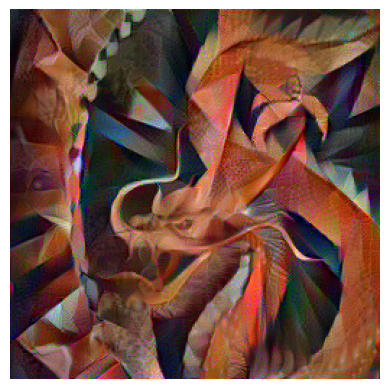

In [58]:
# Plot the target image
plt.imshow(target_img_np.squeeze())
plt.axis('off')  # Optional: Hide axis
plt.show()